In [1]:
import pandas as pd
import numpy as np
import time

from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import accuracy_score

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import seaborn as sns

from collections import Counter

from river import evaluate
from river import metrics

from river import stream, compose, drift
from river import preprocessing
from river import linear_model as ln
from river import multiclass

%matplotlib inline

In [2]:
#Loading the dataset
df= pd.read_csv("/Users/promisea/ALMA/CIC/CIC_DoS_Attack.csv")

In [3]:
df.head(10)

,flow_duration,Header_Length,Protocol Type,Duration,Rate,Srate,Drate,fin_flag_number,syn_flag_number,rst_flag_number,...,Std,Tot size,IAT,Number,Magnitue,Radius,Covariance,Variance,Weight,label
0,5.509630,139.20,6.00,64.00,0.467970,0.467970,0,0,1,0,...,0.000000,54.00,8.298606e+07,9.5,10.392305,0.000000,0.000000,0.00,141.55,1
1,0.127157,14544.78,16.89,64.00,17681.275260,17681.275260,0,0,0,0,...,35.386066,64.24,8.301635e+07,9.5,10.703340,50.151234,12668.274780,0.10,141.55,1
2,0.071306,27863.89,16.78,64.00,10613.219860,10613.219860,0,0,0,0,...,1.031396,50.75,8.301636e+07,9.5,10.035269,1.462431,12.296685,0.09,141.55,1
3,47.982122,2951704.70,8.20,207.10,54.616511,54.616511,0,0,0,0,...,761.763359,98.40,1.665260e+08,13.5,27.423717,1079.465234,586270.886700,1.00,244.60,0
4,0.000000,54.00,6.00,64.00,2.600294,2.600294,0,0,0,0,...,0.000000,54.00,8.295154e+07,9.5,10.392305,0.000000,0.000000,0.00,141.55,1
5,4.279374,108.00,6.00,64.00,0.467358,0.467358,0,0,1,0,...,0.000000,54.00,8.298116e+07,9.5,10.392305,0.000000,0.000000,0.00,141.55,1
6,0.037895,25810.00,16.20,73.55,9915.558244,9915.558244,0,0,0,0,...,0.546646,51.00,8.301174e+07,9.5,10.028005,0.775149,4.410342,0.07,141.55,1
7,0.075904,43021.54,17.00,64.00,25680.515280,25680.515280,0,0,0,0,...,0.549374,50.25,8.301636e+07,9.5,10.014394,0.778825,3.388080,0.09,141.55,1
8,5.580217,110.62,6.00,65.73,0.369285,0.369285,0,0,0,0,...,1.191397,54.20,8.294697e+07,9.5,10.441347,1.686404,8.015752,0.19,141.55,1
9,0.053058,43106.29,16.34,64.00,20442.939130,20442.939130,0,0,0,0,...,2.029618,51.04,8.302863e+07,9.5,10.097023,2.873789,14.567797,0.29,141.55,1


In [4]:
print('Original dataset shape  %s' % Counter(df['label']))

Original dataset shape  Counter({1: 77526, 0: 10525})


In [5]:
X1 = df.drop(['label'], axis=1)
y1 = df['label']

In [6]:
X1, y1 = shuffle(X1, y1, random_state=42)

In [7]:
data=pd.read_csv("/Users/promisea/ALMA/CIC/CIC_Mirai_Attack.csv")

In [8]:
X2 = data.drop(['label'], axis=1)
y2 = data['label']

In [9]:
X2, y2 = shuffle(X2, y2, random_state=42)

In [10]:
dos = stream.iter_pandas(X1, y1)
mirai = stream.iter_pandas(X2, y2)

In [11]:
model = compose.Pipeline(
    preprocessing.StandardScaler(),
    ln.ALMAClassifier(alpha=0.1, B=4.6)
)

In [12]:
from river.metrics import Accuracy
import matplotlib.pyplot as plt
from collections import defaultdict

def process1(dataset1, dataset2, window_size=100):
    performances = defaultdict(list)
    temp_performances = defaultdict(list)
    indices = []

    # Create new instances of the metric for each class
    metrics = {0: Accuracy(), 1: Accuracy()}  

    # Process the first dataset
    for i, (xi, yi) in enumerate(dataset1):
        y_pred = model.predict_one(xi)
        model.learn_one(xi, yi)

        # Update the metric for the respective class
        metrics[yi].update(yi, y_pred)
        temp_performances[yi].append(metrics[yi].get())
        
        # Calculate window average every window_size samples
        if (i + 1) % window_size == 0:
            for key in metrics:
                if temp_performances[key]:  # Check if there are elements
                    average_accuracy = sum(temp_performances[key]) / len(temp_performances[key])
                    performances[key].append(average_accuracy)
                    temp_performances[key].clear()  # Reset the temporary list
            indices.append(i)

    # Print accuracies after processing the first dataset
    print("Accuracies after processing DoS:")
    for key, metric in metrics.items():
        print(f"Class {key}: {metric.get()}")

    end_of_dataset1 = len(indices) * window_size - 1  # Mark the end of the first dataset

    # Process the second dataset
    i_offset = i + 1  # Starting index for the second dataset
    for j, (xi, yi) in enumerate(dataset2, start=i_offset):
        y_pred = model.predict_one(xi)
        model.learn_one(xi, yi)

        # Update the metric for the respective class
        metrics[yi].update(yi, y_pred)
        temp_performances[yi].append(metrics[yi].get())

        # Calculate window average every window_size samples
        if (j + 1 - i_offset) % window_size == 0:
            for key in metrics:
                if temp_performances[key]:  # Check if there are elements
                    average_accuracy = sum(temp_performances[key]) / len(temp_performances[key])
                    performances[key].append(average_accuracy)
                    temp_performances[key].clear()  # Reset the temporary list
            indices.append(j)

    # Print accuracies after processing the datasets
    print("Accuracies after processing Mirai:")
    for key, metric in metrics.items():
        print(f"Class {key}: {metric.get()}")

    # Plotting the accuracies for both classes in a single figure
    plt.figure(figsize=(10, 6))
    for key in performances:
        plt.plot(indices[:len(performances[key])], performances[key], label=f"Class {key} Accuracy")
    plt.axvline(x=end_of_dataset1, color='red', linestyle='--', label='End of DoS')
    plt.xlabel('Number of Samples', fontweight='bold')
    plt.ylabel('Accuracy', fontweight='bold')
    plt.title('Continuous Model Performance of Benign, DoS and Mirai of the CIC 2023 Dataset using ALMA', fontweight='bold')
    
    # Set the tick labels to be bold
    ax = plt.gca()  # Get the current Axes instance
    for label in ax.get_xticklabels() + ax.get_yticklabels():
        label.set_fontweight('bold')
        
    plt.legend()
    plt.savefig('ALMA_CIC_Classes_1.png')
    plt.show()

    return indices, dict(performances)

Accuracies after processing DoS:
Class 0: 0.9558194774346793
Class 1: 0.9785491319041354
Accuracies after processing Mirai:
Class 0: 0.9684085510688836
Class 1: 0.9815256896198931


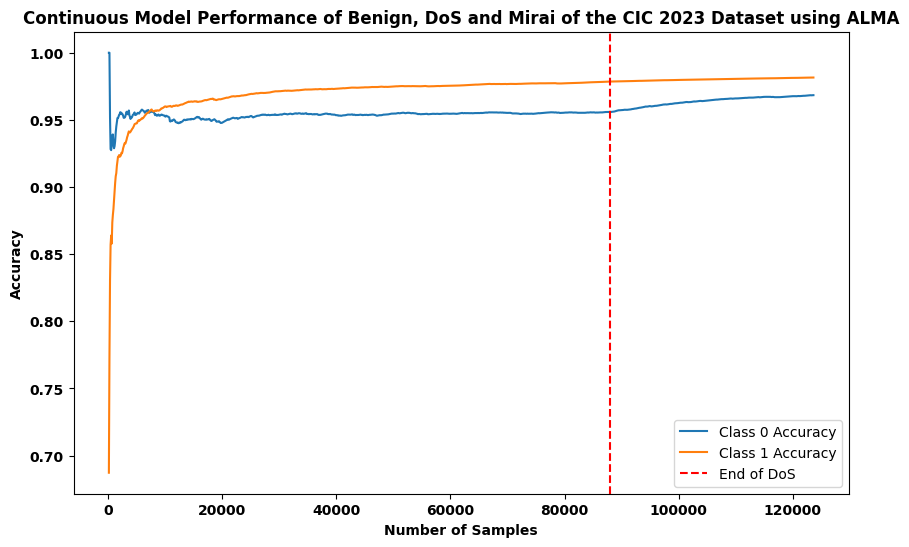

In [13]:
# Process the first dataset
indices, performances = process1(dos, mirai)

In [14]:
model = compose.Pipeline(
    preprocessing.StandardScaler(),
    ln.ALMAClassifier(alpha=0.1, B=4.6)
)

In [15]:
dos = stream.iter_pandas(X1, y1)
mirai = stream.iter_pandas(X2, y2)

In [16]:
from river.metrics import Accuracy
import matplotlib.pyplot as plt
from collections import defaultdict

def process2(dataset1, dataset2, window_size=100):
    performances = defaultdict(list)
    temp_performances = defaultdict(list)
    indices = []

    # Create new instances of the metric for each class
    metrics = {0: Accuracy(), 1: Accuracy()}  

    # Process the first dataset
    for i, (xi, yi) in enumerate(dataset1):
        y_pred = model.predict_one(xi)
        model.learn_one(xi, yi)

        # Update the metric for the respective class
        metrics[yi].update(yi, y_pred)
        temp_performances[yi].append(metrics[yi].get())
        
        # Calculate window average every window_size samples
        if (i + 1) % window_size == 0:
            for key in metrics:
                if temp_performances[key]:  # Check if there are elements
                    average_accuracy = sum(temp_performances[key]) / len(temp_performances[key])
                    performances[key].append(average_accuracy)
                    temp_performances[key].clear()  # Reset the temporary list
            indices.append(i)

    # Print accuracies after processing the first dataset
    print("Accuracies after processing Mirai:")
    for key, metric in metrics.items():
        print(f"Class {key}: {metric.get()}")

    end_of_dataset1 = len(indices) * window_size - 1  # Mark the end of the first dataset

    # Process the second dataset
    i_offset = i + 1  # Starting index for the second dataset
    for j, (xi, yi) in enumerate(dataset2, start=i_offset):
        y_pred = model.predict_one(xi)
        model.learn_one(xi, yi)

        # Update the metric for the respective class
        metrics[yi].update(yi, y_pred)
        temp_performances[yi].append(metrics[yi].get())

        # Calculate window average every window_size samples
        if (j + 1 - i_offset) % window_size == 0:
            for key in metrics:
                if temp_performances[key]:  # Check if there are elements
                    average_accuracy = sum(temp_performances[key]) / len(temp_performances[key])
                    performances[key].append(average_accuracy)
                    temp_performances[key].clear()  # Reset the temporary list
            indices.append(j)

    # Print accuracies after processing the datasets
    print("Accuracies after processing DoS:")
    for key, metric in metrics.items():
        print(f"Class {key}: {metric.get()}")

    # Plotting the accuracies for both classes in a single figure
    plt.figure(figsize=(10, 6))
    for key in performances:
        plt.plot(indices[:len(performances[key])], performances[key], label=f"Class {key} Accuracy")
    plt.axvline(x=end_of_dataset1, color='red', linestyle='--', label='End of Mirai')
    plt.xlabel('Number of Samples', fontweight='bold')
    plt.ylabel('Accuracy', fontweight='bold')
    plt.title('Continuous Model Performance of Benign, Mirai and DoS of the CIC 2023 Dataset using ALMA', fontweight='bold')
    
    # Set the tick labels to be bold
    ax = plt.gca()  # Get the current Axes instance
    for label in ax.get_xticklabels() + ax.get_yticklabels():
        label.set_fontweight('bold')
        
    plt.legend()
    plt.savefig('ALMA_CIC_Classes_2.png')
    plt.show()

    return indices, dict(performances)

Accuracies after processing Mirai:
Class 0: 0.9657007125890736
Class 1: 0.9894434928096244
Accuracies after processing DoS:
Class 0: 0.9577197149643706
Class 1: 0.991474144734919


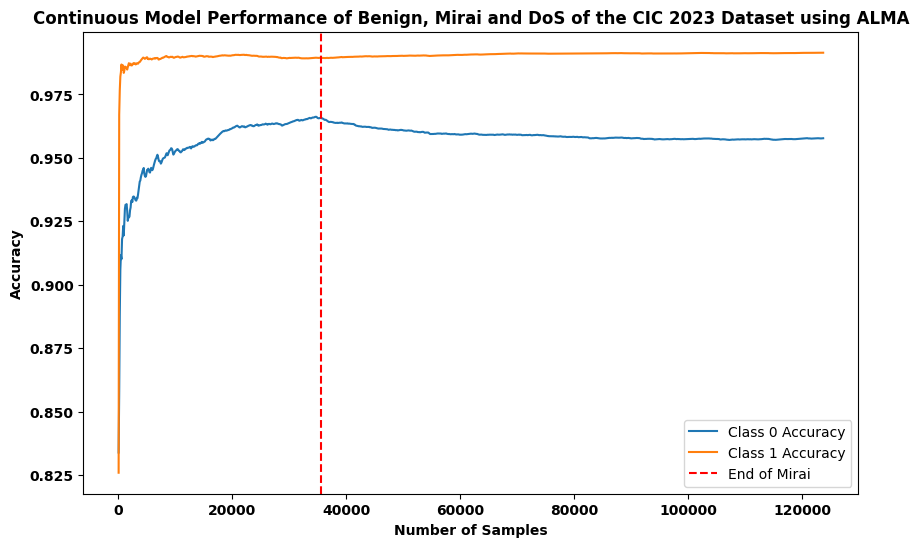

In [17]:
# Process the first dataset
indices, performances = process2(mirai, dos)

In [18]:
data=pd.read_csv("/Users/promisea/ALMA/CIC/CIC_DoS_Attack.csv")

In [19]:
X = data.drop(['label'], axis=1)
y = data['label']

In [20]:
X, y = shuffle(X, y, random_state=42)

In [21]:
dataset = stream.iter_pandas(X, y)

In [22]:
import collections
import math
from collections import deque
from river import base, utils

class DriftALMA(base.Classifier):
    def __init__(self, p=2, alpha=0.9, B=1 / 0.9, C=2**0.5, window_size=500, threshold=0.05):
        self.p = p
        self.alpha = alpha
        self.B = B
        self.C = C
        self.w = collections.defaultdict(float)
        self.k = 1
        self.window_size = window_size
        self.threshold = threshold
        self.error_window = deque(maxlen=window_size)
        self.gamma_log = []
        self.eta_log = []
        self.error_rate_log = []
        self.adjustments_log = []

    def _raw_dot(self, x):
        return utils.math.dot(x, self.w)

    def predict_proba_one(self, x):
        yp = utils.math.sigmoid(self._raw_dot(x))
        return {False: 1 - yp, True: yp}

    def learn_one(self, x, y):
        proba = self.predict_proba_one(x)
        predicted_y = max(proba, key=proba.get)
        actual_y = bool(y)
        error = int(predicted_y != actual_y)
        self.error_window.append(error)
        
        if len(self.error_window) == self.window_size:
            average_error = sum(self.error_window) / self.window_size
            self.error_rate_log.append(average_error)
            if average_error > self.threshold:
                self.handle_drift()

        y = int(y or -1)
        gamma = self.B * math.sqrt(self.p - 1) / math.sqrt(self.k)
        self.gamma_log.append(gamma)
        
        if y * self._raw_dot(x) < (1 - self.alpha) * gamma:
            eta = self.C / (math.sqrt(self.p - 1) * math.sqrt(self.k))
            self.eta_log.append(eta)
            for i, xi in x.items():
                self.w[i] += eta * y * xi

            norm = utils.math.norm(self.w, order=self.p)
            for i in x:
                self.w[i] /= max(1, norm)

            self.k += 1

    def handle_drift(self):
        print("Drift detected.")

In [23]:
drift_model = compose.Pipeline(
    preprocessing.StandardScaler(),
    DriftALMA(alpha=0.1, B=4.6)
)

In [24]:
# Iterate through the dataset
for xi, yi, in dataset:

    # Update the classifier with the new sample
    drift_model.learn_one(xi, yi)

Drift detected.
Drift detected.
Drift detected.
Drift detected.
Drift detected.
Drift detected.
Drift detected.
Drift detected.
Drift detected.
Drift detected.
Drift detected.
Drift detected.
Drift detected.
Drift detected.
Drift detected.
Drift detected.
Drift detected.
Drift detected.
Drift detected.
Drift detected.
Drift detected.
Drift detected.
Drift detected.
Drift detected.
Drift detected.
Drift detected.
Drift detected.
Drift detected.
Drift detected.
Drift detected.
Drift detected.
Drift detected.
Drift detected.
Drift detected.
Drift detected.
Drift detected.
Drift detected.
Drift detected.
Drift detected.
Drift detected.
Drift detected.
Drift detected.
Drift detected.
Drift detected.
Drift detected.
Drift detected.
Drift detected.
Drift detected.
Drift detected.
Drift detected.
Drift detected.
Drift detected.
Drift detected.
Drift detected.
Drift detected.
Drift detected.
Drift detected.
Drift detected.
Drift detected.
Drift detected.
Drift detected.
Drift detected.
Drift de

In [25]:
def plot_error_rate(model):
    plt.figure(figsize=(10, 4))  # Adjust the figure size as needed
    plt.plot(model.error_rate_log, label='Error Rate')
    plt.title('Error Rate Over Iterations - DoS Attack Using ALMA', fontweight='bold')
    plt.ylabel('Error Rate', fontweight='bold')
    plt.xlabel('# Iterations', fontweight='bold')
    plt.legend()
    plt.grid(True)  

    # Set the tick labels to be bold
    ax = plt.gca()  # Get the current Axes instance
    for label in ax.get_xticklabels() + ax.get_yticklabels():
        label.set_fontweight('bold')

    plt.tight_layout()
    plt.savefig('Error_Rate_DoS_CIC.png')
    plt.show()

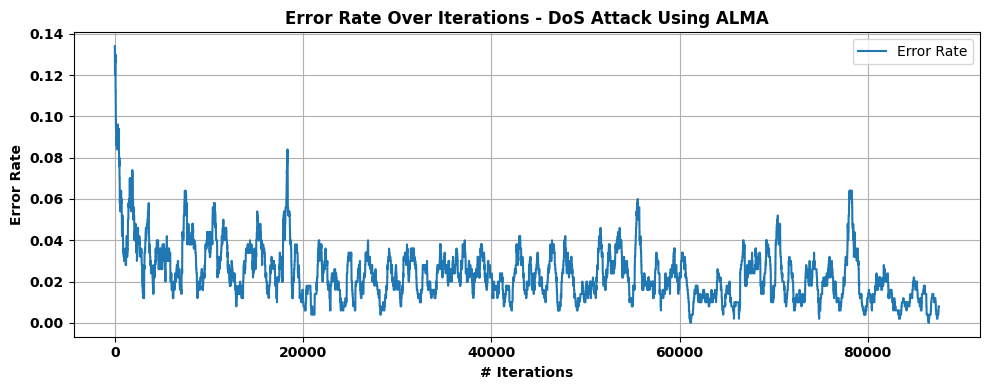

In [26]:
plot_error_rate(drift_model[-1])

In [27]:
dataset = stream.iter_pandas(X, y)

In [28]:
import collections
import math
from collections import deque
from river import base, utils

class DriftALMALearn(base.Classifier):
    def __init__(self, p=2, alpha=0.9, B=1 / 0.9, C=2**0.5, window_size=500, threshold=0.05):
        self.p = p
        self.alpha = alpha
        self.B = B
        self.C = C
        self.w = collections.defaultdict(float)
        self.k = 1
        self.window_size = window_size
        self.threshold = threshold
        self.error_window = deque(maxlen=window_size)
        self.gamma_log = []
        self.eta_log = []
        self.error_rate_log = []
        self.adjustments_log = []

    def _raw_dot(self, x):
        return utils.math.dot(x, self.w)

    def predict_proba_one(self, x):
        yp = utils.math.sigmoid(self._raw_dot(x))
        return {False: 1 - yp, True: yp}

    def learn_one(self, x, y):
        proba = self.predict_proba_one(x)
        predicted_y = max(proba, key=proba.get)
        actual_y = bool(y)
        error = int(predicted_y != actual_y)
        self.error_window.append(error)
        
        if len(self.error_window) == self.window_size:
            average_error = sum(self.error_window) / self.window_size
            self.error_rate_log.append(average_error)
            if average_error > self.threshold:
                self.handle_drift()

        y = int(y or -1)
        gamma = self.B * math.sqrt(self.p - 1) / math.sqrt(self.k)
        self.gamma_log.append(gamma)
        
        if y * self._raw_dot(x) < (1 - self.alpha) * gamma:
            eta = self.C / (math.sqrt(self.p - 1) * math.sqrt(self.k))
            self.eta_log.append(eta)
            for i, xi in x.items():
                self.w[i] += eta * y * xi

            norm = utils.math.norm(self.w, order=self.p)
            for i in x:
                self.w[i] /= max(1, norm)

            self.k += 1

    def handle_drift(self):
        #print("Drift detected.")
        self.C *= 0.98  # Decreasing learning rate
        self.alpha *= 0.12  # Increasing the margin to be less responsive
        self.adjustments_log.append((self.k, self.C, self.alpha))

In [29]:
drift_model_learn = compose.Pipeline(
    preprocessing.StandardScaler(),
    DriftALMALearn(alpha=0.1, B=4.6)
)

In [30]:
# Iterate through the dataset
for xi, yi, in dataset:

    # Update the classifier with the new sample
    drift_model_learn.learn_one(xi, yi)

In [31]:
def plot_error_rate(model):
    plt.figure(figsize=(10, 4))  # Adjust the figure size as needed
    plt.plot(model.error_rate_log, label='Error Rate')
    plt.title('Error Rate Over Iterations - DoS Attack Using Adaptive ALMA', fontweight='bold')
    plt.ylabel('Error Rate', fontweight='bold')
    plt.xlabel('# Iterations', fontweight='bold')
    plt.legend()
    plt.grid(True)  

    # Set the tick labels to be bold
    ax = plt.gca()  # Get the current Axes instance
    for label in ax.get_xticklabels() + ax.get_yticklabels():
        label.set_fontweight('bold')

    plt.tight_layout()
    plt.savefig('Error_Rate_DoS_CIC_Adaptive.png')
    plt.show()

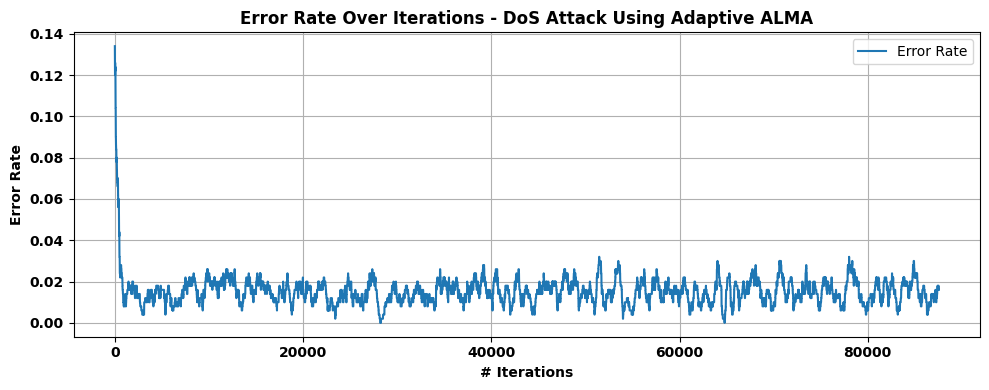

In [32]:
plot_error_rate(drift_model_learn[-1])

In [33]:
dataset = stream.iter_pandas(X, y)

In [34]:
drift_model = compose.Pipeline(
    preprocessing.StandardScaler(),
    DriftALMA(alpha=0.1, B=4.6)
)
#Passing the evalaution metrics into a variable
report = metrics.F1()

In [35]:
%%time

evaluate.progressive_val_score(dataset, drift_model, report, print_every=10000)

Drift detected.
Drift detected.
Drift detected.
Drift detected.
Drift detected.
Drift detected.
Drift detected.
Drift detected.
Drift detected.
Drift detected.
Drift detected.
Drift detected.
Drift detected.
Drift detected.
Drift detected.
Drift detected.
Drift detected.
Drift detected.
Drift detected.
Drift detected.
Drift detected.
Drift detected.
Drift detected.
Drift detected.
Drift detected.
Drift detected.
Drift detected.
Drift detected.
Drift detected.
Drift detected.
Drift detected.
Drift detected.
Drift detected.
Drift detected.
Drift detected.
Drift detected.
Drift detected.
Drift detected.
Drift detected.
Drift detected.
Drift detected.
Drift detected.
Drift detected.
Drift detected.
Drift detected.
Drift detected.
Drift detected.
Drift detected.
Drift detected.
Drift detected.
Drift detected.
Drift detected.
Drift detected.
Drift detected.
Drift detected.
Drift detected.
Drift detected.
Drift detected.
Drift detected.
Drift detected.
Drift detected.
Drift detected.
Drift de

F1: 98.62%

In [36]:
dataset = stream.iter_pandas(X, y)

In [37]:
drift_model_learn = compose.Pipeline(
    preprocessing.StandardScaler(),
    DriftALMALearn(alpha=0.1, B=4.6)
)
#Passing the evalaution metrics into a variable
report = metrics.F1()

In [38]:
%%time

evaluate.progressive_val_score(dataset, drift_model_learn, report, print_every=10000)

[10,000] F1: 98.81%
[20,000] F1: 98.93%
[30,000] F1: 99.04%
[40,000] F1: 99.07%
[50,000] F1: 99.08%
[60,000] F1: 99.09%
[70,000] F1: 99.10%
[80,000] F1: 99.10%
[88,051] F1: 99.10%
CPU times: user 11.3 s, sys: 50.2 ms, total: 11.4 s
Wall time: 12.2 s


F1: 99.10%

In [39]:
#Loading the dataset
data= pd.read_csv("/Users/promisea/ALMA/CIC/CIC_Mirai_Attack.csv")

In [40]:
X2 = data.drop(['label'], axis=1)
y2 = data['label']

In [41]:
X, y = shuffle(X2, y2, random_state=42)

In [42]:
dataset2 = stream.iter_pandas(X, y)

In [43]:
drift_model = compose.Pipeline(
    preprocessing.StandardScaler(),
    DriftALMA(alpha=0.1, B=4.6)
)

In [44]:
# Iterate through the dataset
for xi, yi, in dataset2:

    # Update the classifier with the new sample
    drift_model.learn_one(xi, yi)

In [45]:
def plot_error_rate(model):
    plt.figure(figsize=(10, 4))  # Adjust the figure size as needed
    plt.plot(model.error_rate_log, label='Error Rate')
    plt.title('Error Rate Over Iterations - Mirai Attack Using ALMA', fontweight='bold')
    plt.ylabel('Error Rate', fontweight='bold')
    plt.xlabel('# Iterations', fontweight='bold')
    plt.legend()
    plt.grid(True)  

    # Set the tick labels to be bold
    ax = plt.gca()  # Get the current Axes instance
    for label in ax.get_xticklabels() + ax.get_yticklabels():
        label.set_fontweight('bold')

    plt.tight_layout()
    plt.savefig('Error_Rate_Mirai_CIC.png')
    plt.show()

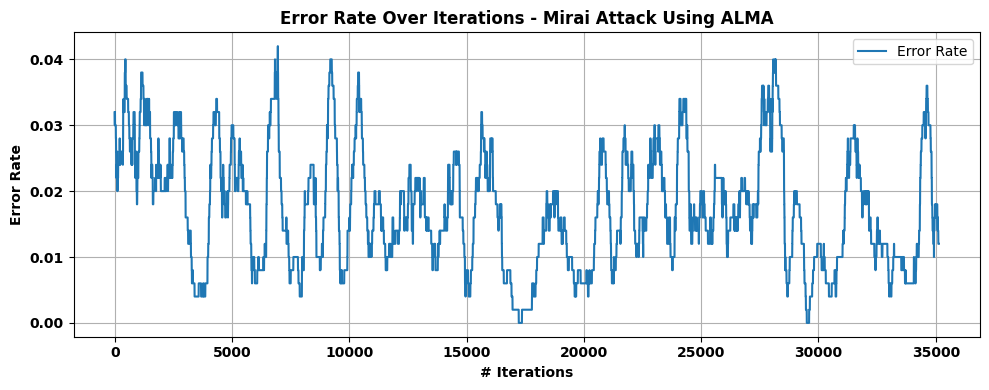

In [46]:
plot_error_rate(drift_model[-1])

In [47]:
dataset2 = stream.iter_pandas(X, y)

In [48]:
drift_model_learn = compose.Pipeline(
    preprocessing.StandardScaler(),
    DriftALMALearn(alpha=0.1, B=4.6)
)

In [49]:
# Iterate through the dataset
for xi, yi, in dataset2:

    # Update the classifier with the new sample
    drift_model_learn.learn_one(xi, yi)

In [50]:
def plot_error_rate(model):
    plt.figure(figsize=(10, 4))  # Adjust the figure size as needed
    plt.plot(model.error_rate_log, label='Error Rate')
    plt.title('Error Rate Over Iterations - Mirai Attack Using Adaptive ALMA', fontweight='bold')
    plt.ylabel('Error Rate', fontweight='bold')
    plt.xlabel('# Iterations', fontweight='bold')
    plt.legend()
    plt.grid(True)  

    # Set the tick labels to be bold
    ax = plt.gca()  # Get the current Axes instance
    for label in ax.get_xticklabels() + ax.get_yticklabels():
        label.set_fontweight('bold')

    plt.tight_layout()
    plt.savefig('Error_Rate_Mirai_CIC_Adaptive.png')
    plt.show()

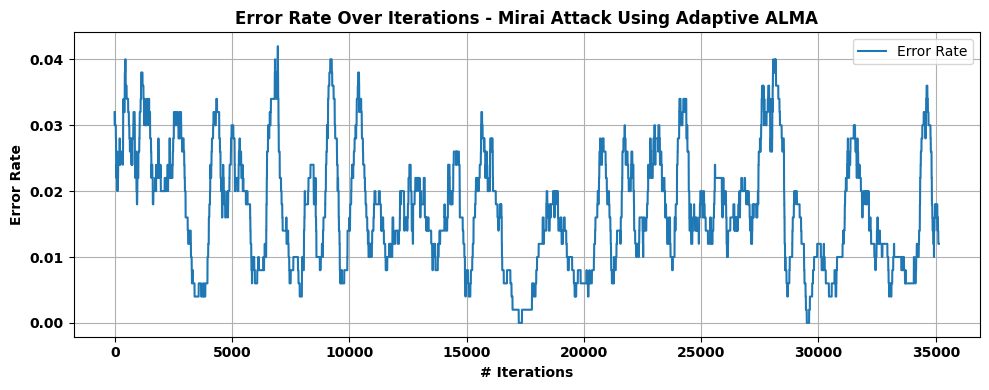

In [51]:
plot_error_rate(drift_model_learn[-1])

In [52]:
dataset2 = stream.iter_pandas(X, y)

In [53]:
drift_model = compose.Pipeline(
    preprocessing.StandardScaler(),
    DriftALMA(alpha=0.1, B=4.6)
)
#Passing the evalaution metrics into a variable
report = metrics.F1()

In [54]:
%%time

evaluate.progressive_val_score(dataset2, drift_model, report, print_every=10000)

[10,000] F1: 98.49%
[20,000] F1: 98.72%
[30,000] F1: 98.71%
[35,628] F1: 98.76%
CPU times: user 4.34 s, sys: 45.5 ms, total: 4.38 s
Wall time: 4.29 s


F1: 98.76%

In [55]:
dataset2 = stream.iter_pandas(X, y)

In [56]:
drift_model_learn = compose.Pipeline(
    preprocessing.StandardScaler(),
    DriftALMALearn(alpha=0.1, B=4.6)
)
#Passing the evalaution metrics into a variable
report = metrics.F1()

In [57]:
%%time

evaluate.progressive_val_score(dataset2, drift_model_learn, report, print_every=10000)

[10,000] F1: 98.49%
[20,000] F1: 98.72%
[30,000] F1: 98.71%
[35,628] F1: 98.76%
CPU times: user 4.34 s, sys: 2.93 ms, total: 4.35 s
Wall time: 4.35 s


F1: 98.76%